In [ ]:
# Import system packages
import os
import sys
import time
import logging
import importlib

#Import data manipulation libraries
import numpy as np
import pandas as pd
import collections
from tqdm import tqdm

#Import visualization libraries
import matplotlib.pyplot as plt

#Importing ML/DL libraries
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,precision_recall_fscore_support, average_precision_score
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix,accuracy_score

import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layer

from tensorflow.keras import initializers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation 
from tensorflow.keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate
import pickle

import random
random.seed(123)



Matplotlib is building the font cache; this may take a moment.


In [3]:
import sys
import sklearn.preprocessing

# Hack to make sklearn think 'label' exists in the preprocessing module
sys.modules['sklearn.preprocessing.label'] = sys.modules['sklearn.preprocessing._label']

import pickle

# Now try loading the pickle
filename = 'preprocessed_data_full.pkl'
with open(filename, 'rb') as input_file:
    preprocessed_data = pickle.load(input_file)

# Now you can work with the preprocessed_data as needed


d:\gans\tf_env\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.0 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
for key in preprocessed_data:
    print(key)  

x_train
y_train
x_test
le
y_test


In [5]:
le = preprocessed_data['le']
x_train = preprocessed_data['x_train']
y_train = preprocessed_data['y_train']
x_test = preprocessed_data['x_test']
y_test = preprocessed_data['y_test']

In [6]:
np.unique(y_train)

array([ 0,  5,  9, 10, 11, 15, 17, 18, 20, 21], dtype=int64)

In [7]:
#Obtain the class number for Normal entries 
pd.DataFrame(le.classes_, columns = ['Type'])

,Type
0,back.
1,buffer_overflow.
2,ftp_write.
3,guess_passwd.
4,imap.
5,ipsweep.
6,land.
7,loadmodule.
8,multihop.
9,neptune.


In [8]:
# Converting labels to Binary

y_test[y_test != 11] = 1 
y_test[y_test == 11] = 0
y_train[y_train != 11] = 1
y_train[y_train == 11] = 0

In [9]:
#Subsetting only Normal Network packets in our training set

temp_df = x_train.copy()
temp_df['label'] = y_train
temp_df = temp_df.loc[temp_df['label'] == 0]
temp_df = temp_df.drop('label', axis = 1)
x_train = temp_df.copy()

In [10]:
# Normalize the above splits using the MinMaxScaler from the scikit learn package
scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#Creating dataset dictionary 
dataset = {}
dataset['x_train'] = x_train.astype(np.float32)
dataset['y_train'] = y_train.astype(np.float32)
dataset['x_test']  = x_test.astype(np.float32)
dataset['y_test']  = y_test.astype(np.float32)

In [11]:
# Defining the Generator network

def get_generator(optimizer):
    
    generator = Sequential()
    generator.add(Dense(64, input_dim=114, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
       
    generator.add(Dense(512))
    generator.add(Activation('tanh'))
   
    generator.add(Dense(114, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return generator

In [12]:
##### Defining the Discriminator network

def get_discriminator(optimizer):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=114, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
       
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    return discriminator

In [13]:
def get_gan_network(discriminator, generator, optimizer,input_dim=114):

    discriminator.trainable = False   
    gan_input = Input(shape=(input_dim,))  
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return gan

In [16]:
from tensorflow.keras.optimizers.legacy import Adam

learning_rate = 0.00001
batch_size = 512
epochs = 10
adam = Adam(learning_rate=learning_rate, beta_1=0.5)


In [ ]:
#Training the GAN
x_train, y_train, x_test, y_test = dataset['x_train'], dataset['y_train'],dataset['x_test'],dataset['y_test']

#Calculating the number of batches based on the batch size
batch_count = x_train.shape[0] // batch_size
pbar = tqdm(total=epochs * batch_count)
gan_loss = []
discriminator_loss = []

#Inititalizing the network
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = get_gan_network(discriminator, generator, adam,input_dim=114)


for epoch in range(epochs):        
    for index in range(batch_count):        
        pbar.update(1)        
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size,114])
        
        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)
        
        #Obtain a batch of normal network packets
        image_batch = x_train[index * batch_size: (index + 1) * batch_size]
            
        X = np.vstack((generated_images,image_batch))       
        y_dis = np.ones(2*batch_size) 
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss= discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, 114])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)
        
        #Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)
        
    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" % (epoch,index,batch_count, d_loss, g_loss))
              

  0%|          | 1/14250 [10:02<2384:19:32, 602.40s/it]


Epoch 0 Batch 1424/1425 [D loss: 0.103087] [G loss:0.021694]


Epoch 1 Batch 1424/1425 [D loss: 0.026796] [G loss:0.002620]


Epoch 2 Batch 1424/1425 [D loss: 0.025548] [G loss:0.001634]


Epoch 3 Batch 1424/1425 [D loss: 0.016146] [G loss:0.000773]


Epoch 4 Batch 1424/1425 [D loss: 0.010280] [G loss:0.000828]


Epoch 5 Batch 1424/1425 [D loss: 0.019522] [G loss:0.001131]


Epoch 6 Batch 1424/1425 [D loss: 0.013451] [G loss:0.001760]


Epoch 7 Batch 1424/1425 [D loss: 0.021882] [G loss:0.000695]


Epoch 8 Batch 1424/1425 [D loss: 0.004338] [G loss:0.000507]


Epoch 9 Batch 1424/1425 [D loss: 0.008011] [G loss:0.001135]


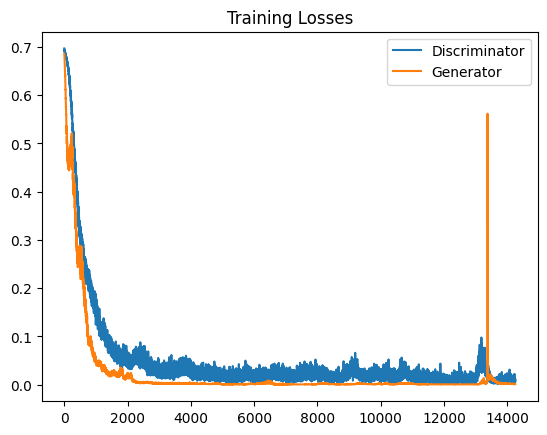

In [18]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()

In [19]:
# Predictions on the test set

nr_batches_test = np.ceil(x_test.shape[0] // batch_size).astype(np.int32)

results =[]

for t in range(nr_batches_test +1):    
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = x_test[ran_from:ran_to]             
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=128,verbose=0)        
        results = np.append(results, tmp_rslt)   

In [20]:
pd.options.display.float_format = '{:20,.7f}'.format
results_df = pd.concat([pd.DataFrame(results),pd.DataFrame(y_test)], axis=1)
results_df.columns = ['results','y_test']
print ('Mean score for normal packets :', results_df.loc[results_df['y_test'] == 0, 'results'].mean() )
print ('Mean score for anomalous packets :', results_df.loc[results_df['y_test'] == 1, 'results'].mean())

Mean score for normal packets : 0.9986744467308589
Mean score for anomalous packets : 0.08145507385207239


In [21]:
#Obtaining the lowest 1% score
per = np.percentile(results,1)
y_pred = results.copy()
y_pred = np.array(y_pred)

#Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1


In [22]:
precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(y_test, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.9992386830438021
Precision : 0.9637769637769638
Recall : 0.9602595296025953
F1 : 0.9620150314848669


Confusion Matrix :


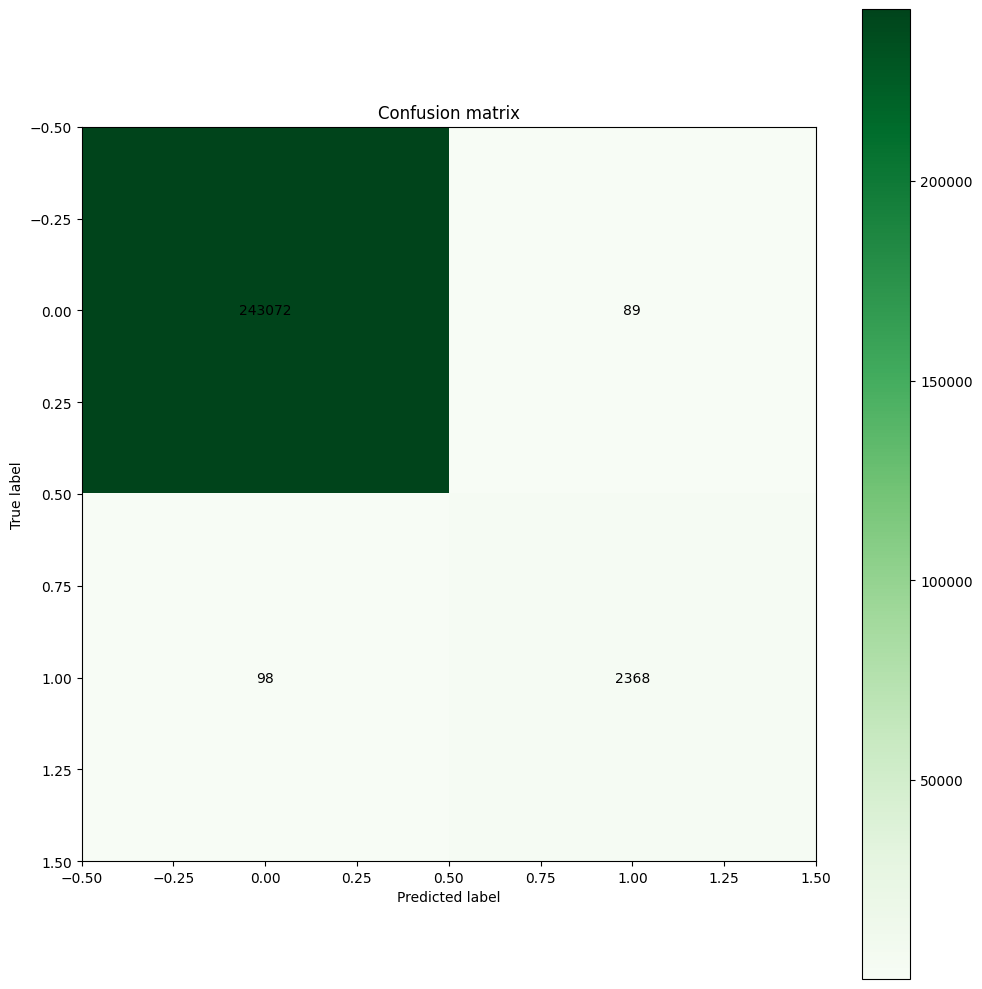

In [23]:
cm = confusion_matrix(y_test, y_pred)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm)

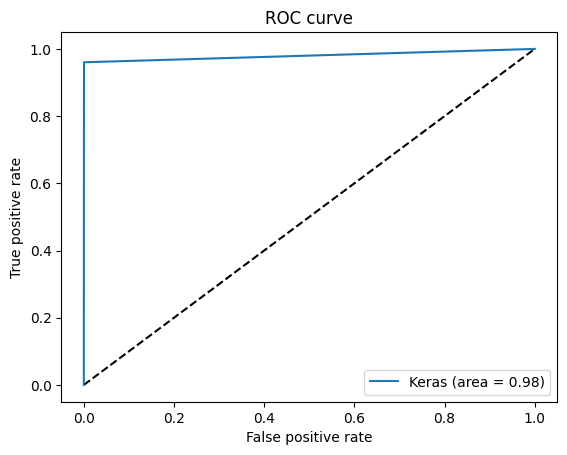

In [24]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.2f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()